In [1]:
# Apply RF models to the reflectance + VI data in order to classify/predict disease status


In [2]:
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import scipy

In [3]:
# Load data for all 3 years
data_2020 = pd.read_csv('../data/img_scout_dfs/2020/INC_coreg_skysat_scout_2020.csv')
data_2021 = pd.read_csv('../data/img_scout_dfs/2021/INC_skysat_scout_2021.csv')
data_2022 = pd.read_csv('../data/img_scout_dfs/2022/INC_skysat_scout_2022.csv')

df_list = [data_2020, data_2021, data_2022]

In [4]:
def add_vis(df):
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['nir_blue'] = (df['nir']-df['blue'])/(df['nir']+df['blue'])
    df['nir_green'] = (df['nir']-df['green'])/(df['nir']+df['green'])
    df['red_blue'] = (df['red']-df['blue'])/(df['red']+df['blue'])
    df['green_red'] = (df['green']-df['red'])/(df['green']+df['red'])
    df['green_blue'] = (df['green']-df['blue'])/(df['green']+df['blue'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    df['gri']=df['green']/df['red']

    
    return df

In [5]:
# Add columns for VIs, GDM incidence, and GDM severity to each df 
for d in df_list:
    add_vis(d)
    
    d['GDM_sev']='low'
    d.loc[d['DM_severity'] > 10, 'GDM_sev'] = 'high'
    
    d['GDM_inc']='low'
    d.loc[d['DM_inc'] > 25, 'GDM_inc'] = 'high'

In [6]:
# Create master df
data_all = pd.concat(df_list)

#Check master df size
data_all.shape

(2414, 30)

Low severity: 710
High severity: 10
Proportion: 71.0 : 1
Low inc: 694
High inc: 26
Proportion: 26.69 : 1


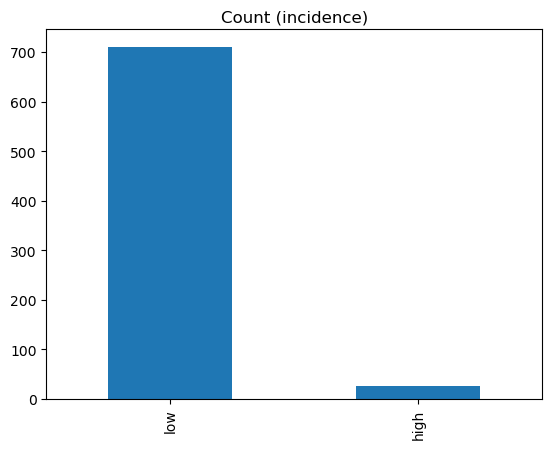

In [7]:
# Visualize data imbalance

target_count = data_2022.GDM_sev.value_counts()
print('Low severity:', target_count[0])
print('High severity:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (severity)');

inc_count = data_2022.GDM_inc.value_counts()
print('Low inc:', inc_count[0])
print('High inc:', inc_count[1])
print('Proportion:', round(inc_count[0] / inc_count[1], 2), ': 1')

inc_count.plot(kind='bar', title='Count (incidence)');

In [8]:
# The following code is adapted from "Introduction of Python and Machine Learning in Phytopathology.ipynb"

In [9]:
# All variables

data_all.columns

Index(['acquired', 'plot', 'blue', 'green', 'red', 'nir', 'row', 'panel',
       'Date', 'Treatment', 'Block', 'PM_severity', 'DM_severity', 'total_dis',
       'geometry', 'centroid', 'PM_inc', 'DM_inc', 'ndvi', 'nir_blue',
       'nir_green', 'red_blue', 'green_red', 'green_blue', 'evi', 'savi',
       'arvi', 'gri', 'GDM_sev', 'GDM_inc'],
      dtype='object')

In [10]:
# create separate data frames for Explanatory and Response variables:
expl_vars = ['blue', 'green', 'red', 'nir',
             'ndvi', 'nir_blue','nir_green', 'red_blue', 'green_red', 'green_blue', 
             'evi', 'savi','arvi', 'gri']
resp_var = "GDM_sev"
print("Predicting", resp_var , "from", expl_vars)

# selecting explainatory and response variables from data frame
X = data_2020[expl_vars] # Explanatory variables
y = data_2020[resp_var]  # Response variable

Predicting GDM_sev from ['blue', 'green', 'red', 'nir', 'ndvi', 'nir_blue', 'nir_green', 'red_blue', 'green_red', 'green_blue', 'evi', 'savi', 'arvi', 'gri']


In [11]:
from sklearn.model_selection import train_test_split 

# Split dataset into training set and test set
SPLIT_RND_SEED = 123
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED,
                                                    stratify=y)  

print("Using", len(X_train), "panels for training,", len(y_test), "panels for testing")

Using 349 panels for training, 150 panels for testing


In [12]:
# check the shape of X_train and X_test
X_train.shape, X_test.shape

((349, 14), (150, 14))

In [13]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Create a Gaussian Classifier with 500 trees 
rf = RandomForestClassifier(n_estimators = 500, 
                                   oob_score=True, 
                                   random_state=12345, # random number to be used, needed to reproduce the same result
                                   verbose=False)

In [14]:
# Train the model using the training sets
rf_model = rf.fit(X_train, y_train)

# printing rhe classifier object shows its parameters
print(rf_model)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=12345,
                       verbose=False)


In [15]:
# Out of bag score
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')

Out-of-bag score estimate: 0.94


In [16]:
# Prediction on test data
y_pred = rf.predict(X_test)

Text(41.722222222222214, 0.5, 'Predicted GDM Severity')

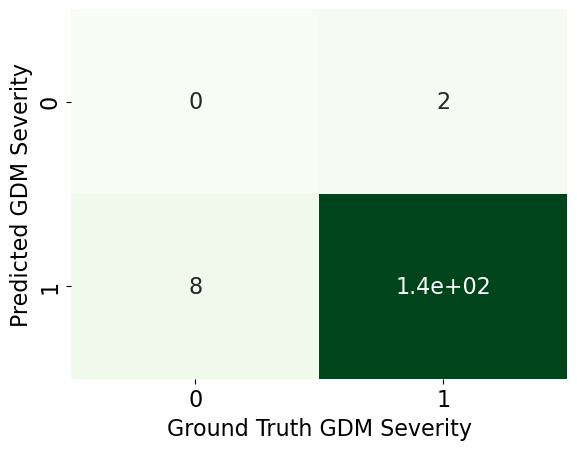

In [17]:
# Confusion (error) Matrix of Prediction
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
  
# use seaborn to plot matrix as heatmap    
plt.rc('font', size=16)
p = sns.heatmap(cm,
                annot=True,
                cbar=False,
                cmap="Greens")
plt.xlabel('Ground Truth GDM Severity')
plt.ylabel('Predicted GDM Severity')

In [18]:
# Accuracy assessment
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is {:.3f}'.format(accuracy))

Model accuracy is 0.933


In [19]:
from sklearn.metrics import classification_report 

# Classification report
stats = classification_report(y_test, y_pred,
                              labels=None,
                              target_names=["high", "low"],
                              sample_weight=None,
                              digits=2,
                              output_dict=False)
  
print("Classification report:\n")
print(stats) 

Classification report:

              precision    recall  f1-score   support

        high       0.00      0.00      0.00         8
         low       0.95      0.99      0.97       142

    accuracy                           0.93       150
   macro avg       0.47      0.49      0.48       150
weighted avg       0.90      0.93      0.91       150



In [20]:
# Try resampling to improve prediction of the under-represented class (high GDM severity)

import imblearn as imb

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Check number of high dis/low dis samples in resampled set
print('resampled counts:', y_resampled.value_counts())

# Compare to original dataset
print('original counts:', y.value_counts())

resampled counts: high    27
low     27
Name: GDM_sev, dtype: int64
original counts: low     472
high     27
Name: GDM_sev, dtype: int64


In [21]:
# Split dataset into training set and test set
SPLIT_RND_SEED = 456
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED)  # 70% training and 30% test

print("Using", len(X_train_us), "panels for training,", len(y_test_us), "panels for testing")

Using 37 panels for training, 17 panels for testing


In [22]:
# Train the model using the training sets
rf_model_us = rf.fit(X_train_us, y_train_us)

# printing rhe classifier object shows its parameters
print(rf_model_us)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=12345,
                       verbose=False)


In [23]:
# Prediction on test data
y_pred_us = rf.predict(X_test_us)

Text(0.5, 1.0, 'RF-UnderSampled 2020 GDM Severity')

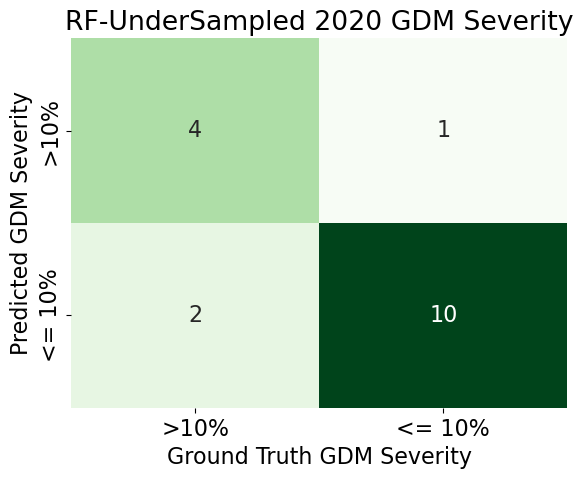

In [24]:
# Confusion (error) Matrix of Prediction
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_pred_us, y_test_us))
  
# use seaborn to plot matrix as heatmap    
plt.rc('font', size=16)
p = sns.heatmap(cm,
                annot=True,
                cbar=False,
                cmap="Greens",
               xticklabels=['>10%', '<= 10%'],
               yticklabels=['>10%', '<= 10%'])
plt.xlabel('Ground Truth GDM Severity')
plt.ylabel('Predicted GDM Severity')
plt.title('RF-UnderSampled 2020 GDM Severity')

In [25]:
# Accuracy assessment

accuracy_us = accuracy_score(y_test_us, y_pred_us)
print('Model accuracy is {:.3f}'.format(accuracy_us))

Model accuracy is 0.824


In [26]:
# Classification report
stats_us = classification_report(y_test_us, y_pred_us,
                              labels=None,
                              target_names=["high", "low"],
                              sample_weight=None,
                              digits=2,
                              output_dict=False)
  
print("Classification report:\n")
print(stats_us) 

Classification report:

              precision    recall  f1-score   support

        high       0.80      0.67      0.73         6
         low       0.83      0.91      0.87        11

    accuracy                           0.82        17
   macro avg       0.82      0.79      0.80        17
weighted avg       0.82      0.82      0.82        17



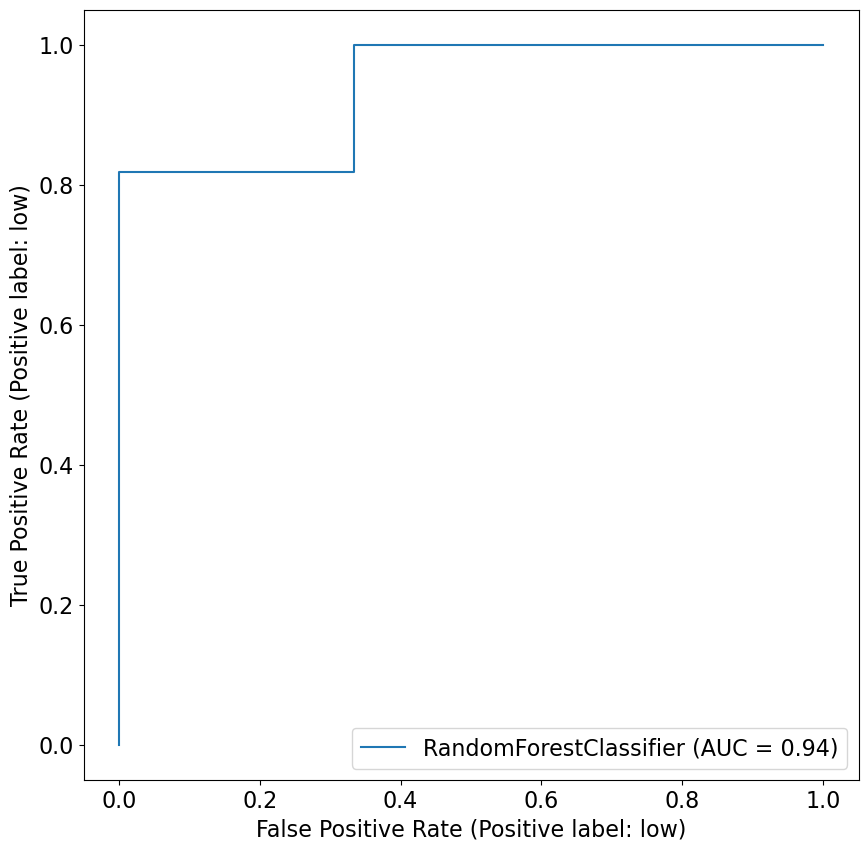

In [27]:
from sklearn.metrics import RocCurveDisplay

# display the predictions
plt.rcParams['figure.figsize'] = [10, 10]
RocCurveDisplay.from_estimator(rf, X_test_us, y_test_us)

In [28]:
from sklearn.metrics import cohen_kappa_score

#def kappa_statistics(X_test, y_test): 
y_pred_us = rf.predict(X_test_us)    
cohen_score = cohen_kappa_score(y_test_us, y_pred_us)    
print("Kappa score:", cohen_score)

Kappa score: 0.5984251968503937


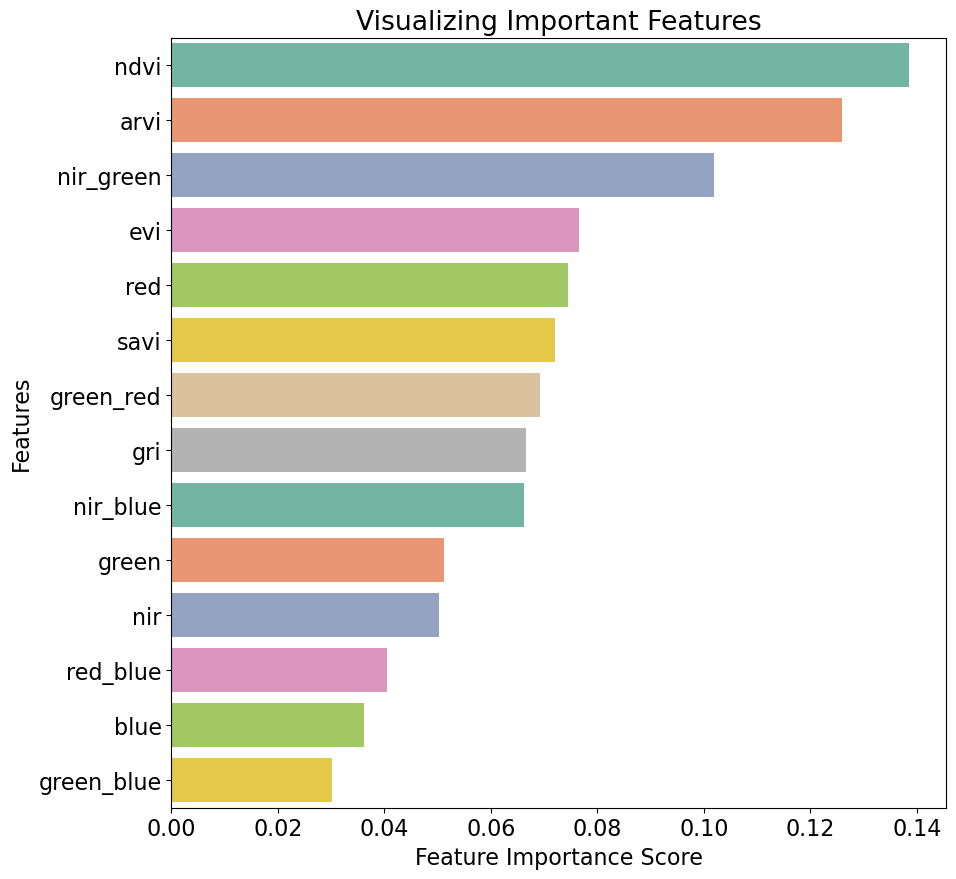

In [29]:
# view the feature scores
feature_scores = pd.Series(rf.feature_importances_, index=X_train_us.columns).sort_values(ascending=False)
feature_scores

# display the predictions
plt.rcParams['figure.figsize'] = [10, 10]

palette = sns.color_palette("Set2")

# Creating a seaborn bar plot
sns.barplot(x=feature_scores, y=feature_scores.index, palette=palette)
plt.title("Visualizing Important Features")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

plt.show()

In [30]:
# Check if an incidence model performs better

# create separate data frames for Explanatory and Response variables:
expl_vars = ['blue', 'green', 'red', 'nir',
             'ndvi', 'nir_blue','nir_green', 'red_blue', 'green_red', 'green_blue', 
             'evi', 'savi','arvi', 'gri']
resp_var_inc = "GDM_inc"
print("Predicting", resp_var_inc , "from", expl_vars)

# selecting explainatory and response variables from data frame
X_inc = data_2020[expl_vars] # Explanatory variables
y_inc = data_2020[resp_var_inc]  # Response variable

Predicting GDM_inc from ['blue', 'green', 'red', 'nir', 'ndvi', 'nir_blue', 'nir_green', 'red_blue', 'green_red', 'green_blue', 'evi', 'savi', 'arvi', 'gri']


In [31]:
# Undersample majority class

X_inc_us, y_inc_us = rus.fit_resample(X_inc, y_inc)

# Check number of high dis/low dis samples in resampled set
print('resampled counts:', y_inc_us.value_counts())

# Compare to original dataset
print('original counts:', y_inc.value_counts())

resampled counts: high    118
low     118
Name: GDM_inc, dtype: int64
original counts: low     381
high    118
Name: GDM_inc, dtype: int64


In [32]:
# First try with original dataset (no undersampling)

# Split dataset into training set and test set
SPLIT_RND_SEED = 789
X_inc_train, X_inc_test, y_inc_train, y_inc_test = train_test_split(X_inc, y_inc,
                                                    test_size=0.3, 
                                                    random_state=SPLIT_RND_SEED)  # 70% training and 30% test

print("Using", len(X_inc_train), "panels for training,", len(y_inc_test), "panels for testing")

Using 349 panels for training, 150 panels for testing


In [33]:
# Train the model using the training sets
rf_model_inc = rf.fit(X_inc_train, y_inc_train)

# printing rhe classifier object shows its parameters
print(rf_model_inc)

RandomForestClassifier(n_estimators=500, oob_score=True, random_state=12345,
                       verbose=False)


In [34]:
# Prediction on test data
y_pred_inc = rf.predict(X_inc_test)

Text(0.5, 1.0, 'RF 2020 GDM Incidence')

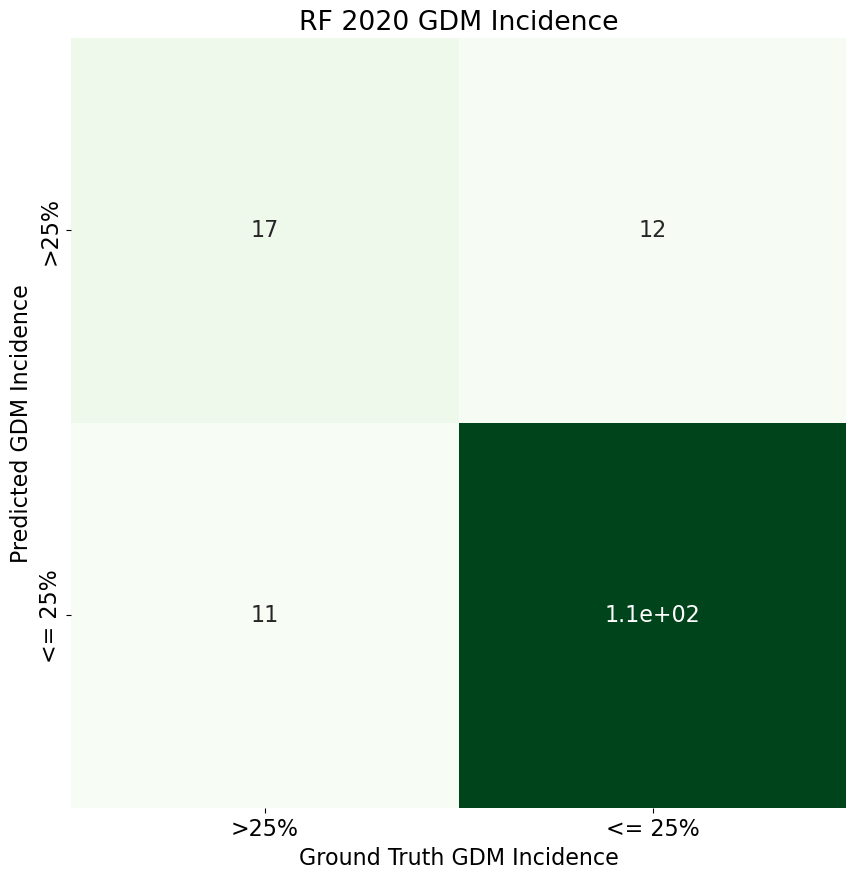

In [35]:
cm = pd.DataFrame(confusion_matrix(y_pred_inc, y_inc_test))
  
# use seaborn to plot matrix as heatmap    
plt.rc('font', size=16)
p = sns.heatmap(cm,
                annot=True,
                cbar=False,
                cmap="Greens",
               xticklabels=['>25%', '<= 25%'],
               yticklabels=['>25%', '<= 25%'])
plt.xlabel('Ground Truth GDM Incidence')
plt.ylabel('Predicted GDM Incidence')
plt.title('RF 2020 GDM Incidence')

In [36]:
# Accuracy assessment

accuracy_inc = accuracy_score(y_inc_test, y_pred_inc)
print('Model accuracy is {:.3f}'.format(accuracy_inc))

Model accuracy is 0.847


In [37]:
# Classification report
stats_inc = classification_report(y_inc_test, y_pred_inc,
                              labels=None,
                              target_names=["high", "low"],
                              sample_weight=None,
                              digits=2,
                              output_dict=False)
  
print("Classification report:\n")
print(stats_inc) 

Classification report:

              precision    recall  f1-score   support

        high       0.59      0.61      0.60        28
         low       0.91      0.90      0.91       122

    accuracy                           0.85       150
   macro avg       0.75      0.75      0.75       150
weighted avg       0.85      0.85      0.85       150



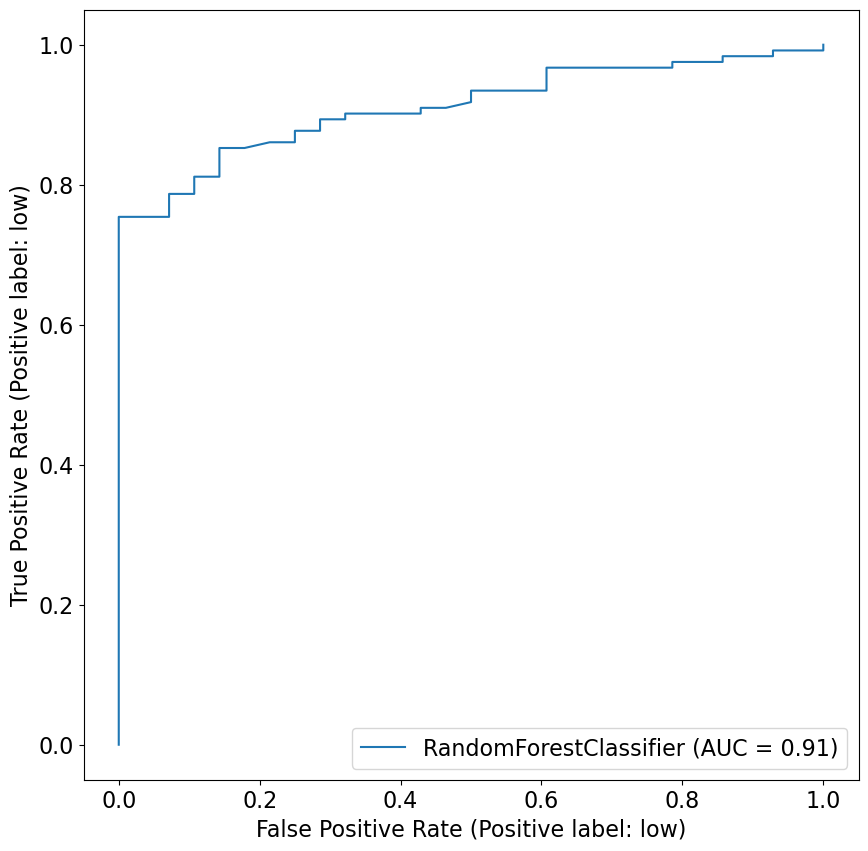

In [38]:
from sklearn.metrics import RocCurveDisplay

# display the predictions
plt.rcParams['figure.figsize'] = [10, 10]
RocCurveDisplay.from_estimator(rf, X_inc_test, y_inc_test)

In [39]:
#def kappa_statistics(X_test, y_test): 

y_pred_inc = rf.predict(X_inc_test)    
cohen_score_inc = cohen_kappa_score(y_inc_test, y_pred_inc)    
print("Kappa score:", cohen_score_inc)

Kappa score: 0.5018769852728848


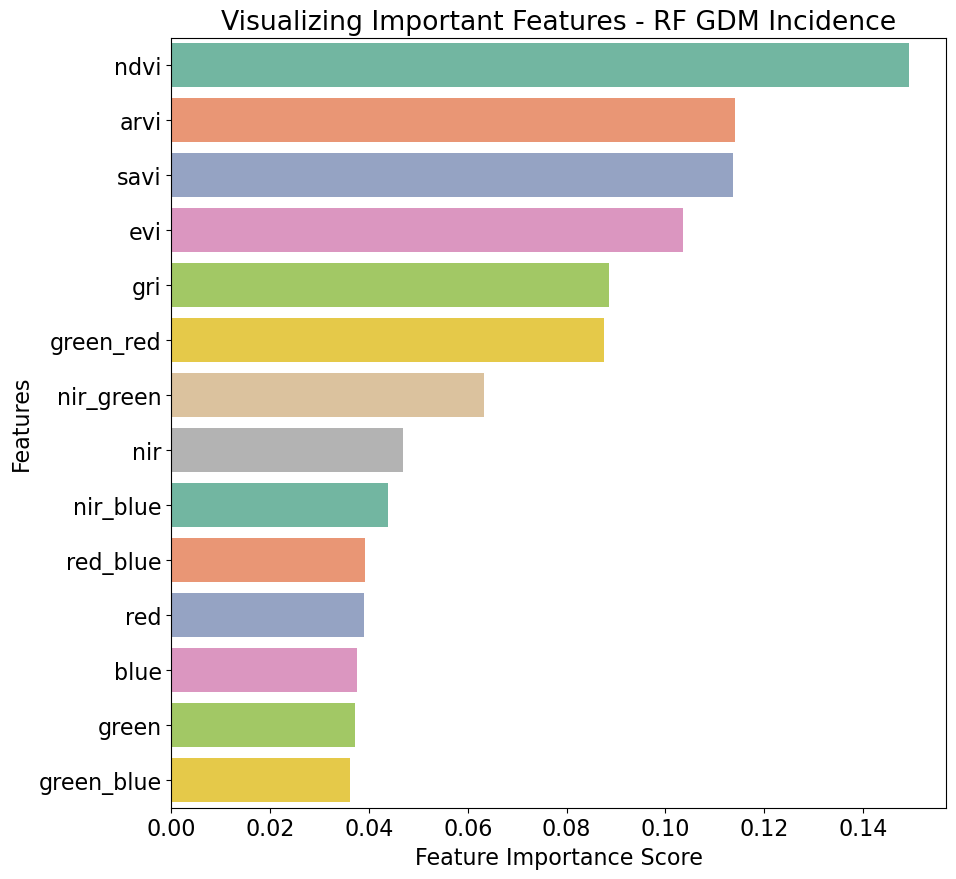

In [40]:
# view the feature scores
feature_scores_inc = pd.Series(rf.feature_importances_, index=X_inc_train.columns).sort_values(ascending=False)
feature_scores_inc

# display the predictions
plt.rcParams['figure.figsize'] = [10, 10]

palette = sns.color_palette("Set2")

# Creating a seaborn bar plot
sns.barplot(x=feature_scores_inc, y=feature_scores_inc.index, palette=palette)
plt.title("Visualizing Important Features - RF GDM Incidence")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

plt.show()

In [ ]:
# Function to run model and save plots
# Params: 
## dataframe
## explanatory vars
## response var
## num_estimators
## rd_state

## if statements for undersampling and disease incidence/severity (to set plot labels)